Use Colab Pro with GPU and High-RAM

# Check GPU

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Dec 12 18:50:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Run this command once and restart the runtime

In [3]:
!pip install av

     |████████████████████████████████| 36.9MB 146kB/s 


# Video Frame Stacking (SG3I)

In [4]:
from google.colab.patches import cv2_imshow
import cv2 as cv
import numpy as np


def getSG3I(videos):
    bz = videos.size(0)

    frame_list_batch = []

    for b in range(bz):
        images = videos[b]

        w = images[0].size(0)
        h = images[0].size(1)
        num_frames = images.size(0)
        frame_list = []

        for i in range(0, num_frames):
            frame_list.append(cv.cvtColor(images[i].numpy(), cv.COLOR_BGR2GRAY))

        frame_list_batch.append(np.stack(frame_list, axis=-1))

    SG3I = np.stack(frame_list_batch, axis=0)
    #cv2_imshow(SG3I[0])

    return torch.Tensor(SG3I)

# Mount drive


In [5]:
import os
import io
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/drive'

drive.mount(DRIVE_MOUNT)


# create folder to write data to
DATA_FOLDER = os.path.join(DRIVE_MOUNT, 'Shared drives', 'CIS680 Final Project', 'data')

Mounted at /content/drive


# Load Dataset

In [ ]:
import matplotlib.pyplot as plt

train_size = 138
test_size = 41

train_path = DATA_FOLDER + "/dataset_3/train/train_b"
test_path = DATA_FOLDER + "/dataset_3/test/test_b"

train_loader = []
test_loader = []

for batch in range(train_size):
    batch_path = train_path + str(batch) + ".pt"
    train_loader.append(torch.load(batch_path))
    if batch % 10 == 0:
        print("train: " + str(batch) + "/" + str(train_size))

for batch in range(test_size):
    batch_path = test_path + str(batch) + ".pt"
    test_loader.append(torch.load(batch_path))
    if batch % 10 == 0:
        print("test: " + str(batch) + "/" + str(test_size))


train: 0/138
train: 10/138
train: 20/138
train: 30/138
train: 40/138
train: 50/138
train: 60/138
train: 70/138
train: 80/138
train: 90/138
train: 100/138
train: 110/138
train: 120/138
train: 130/138
test: 0/41
test: 10/41
test: 20/41
test: 30/41
test: 40/41


# Debugging Visualization

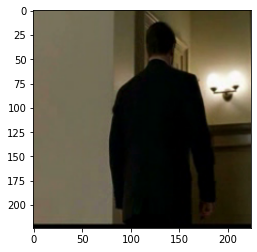

In [ ]:
import torchvision.transforms as tf


transform = tf.RandomHorizontalFlip(p=0.5)

for iter, data in enumerate(train_loader, 0):
    videos = data["videos"]
    labels = data["labels"]
    indexes = data["indexes"]

    videos = transform(videos.permute(0,1,4,2,3)).permute(0,1,3,4,2)

    plt.imshow(videos[0][0])

    SG3I = getSG3I(videos)

    if iter == 0:
      break
    


# Temporal Model

In [6]:
import torch
from torch.nn import functional as F
from torchvision import transforms
from torch import nn, Tensor
import random
import torchvision
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as tf


class TemporalStream(torch.nn.Module):

    def __init__(self,
                 device='cuda',
                 num_classes=51,
                 dropout_probability=0.5):

        # Initialize the stream layers
        super(TemporalStream, self).__init__()
        self.device = device
        self.num_classes = num_classes

        # Backbone
        self.temporal = models.resnet50(pretrained=True)
        for param in self.temporal.parameters():
            param.requires_grad = True

        self.temporal.fc = nn.Sequential(nn.Linear(2048, 1024),
                                nn.ReLU(),
                                nn.Dropout(p=dropout_probability),
                                nn.Linear(1024, self.num_classes),
                                nn.ReLU(),
                                nn.Dropout(p=dropout_probability),
                                nn.Softmax())
      
    def forward(self, X):
        X = self.temporal(X)
        return X

    def compute_loss(self, output, target):
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target)
        return loss


# Train & Test

In [7]:
def train(epoch):
    temporal.train()
    counter = 0
    train_loss = 0
    log_interval = 10
    save_interval = 200

    epoch_loss = []
    log_int_loss = 0
    for iter, data in enumerate(train_loader, 0):

        # Unpack data
        videos = data["videos"]
        labels = torch.tensor(data["labels"])
        indexes = data["indexes"]

        # Input Transforms
        videos = videos.type(torch.FloatTensor)
        videos = transform(videos.permute(0,1,4,2,3)).permute(0,1,3,4,2)

        # Frame Stacking
        SG3I = getSG3I(videos)
        SG3I = SG3I.permute(0,3,1,2)
        SG3I = SG3I.to(device)

        # Output
        optimizer.zero_grad()
        output = temporal(SG3I)
        output = output.to(device)
        labels = labels.to(device)

        # calculate losses
        loss = temporal.compute_loss(output, labels)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Logging Interval
        log_int_loss += loss.item()
        epoch_loss.append(loss.item())

        if counter == 0:
            print('Epoch: ', epoch, ', Batch: ', iter, ', loss avg over log interval: ', log_int_loss)
            train_loss_list.append(train_loss / batch_size)
            train_counter.append((iter + 1) * batch_size + epoch * len(train_loader))
            log_int_loss = 0
        elif counter % log_interval == log_interval - 1:
            print('Epoch: ', epoch, ', Batch: ', iter, ', loss avg over log interval: ', log_int_loss / log_interval)
            train_loss_list.append(train_loss / batch_size)
            train_counter.append((iter + 1) * batch_size + epoch * len(train_loader))
            log_int_loss = 0

        counter += 1

    avg_loss = sum(epoch_loss) / len(epoch_loss)
    epoch_loss_list.append(avg_loss)
    print('Epoch: ', epoch, ', avg total loss: ', avg_loss)


def test():
    temporal.eval()
    test_loss = 0
    correct = 0

    # Data Loop
    with torch.no_grad():
        for iter, data in enumerate(test_loader, 0):

            # Unpack data
            videos = data["videos"]
            labels = torch.tensor(data["labels"])
            indexes = data["indexes"]

            # Input
            videos = videos.type(torch.FloatTensor)
            labels = labels.to(device)
            SG3I = getSG3I(videos)
            SG3I = SG3I.permute(0,3,1,2)
            SG3I = SG3I.to(device)

            # Output
            output = temporal(SG3I)
            output = output.to(device)

            # calculate losses
            loss = temporal.compute_loss(output, labels)

            test_loss += loss.item()

            # calculate number of correct predictions in batch
            correct += sum(torch.argmax(output,1) == labels).item()
            if iter % 100 == 0:
                print ("iter  ", iter)
                print("accuracy so far = ", correct / ((iter + 1) * len(labels)))
    
    # Log
    test_loss_list.append(test_loss / len(test_loader))
    accuracy = correct / (len(test_loader) * 128)
    accuracy_list.append(accuracy)
    print('Avg Validation Loss: ', test_loss / len(test_loader))
    print('Accuracy: ', accuracy)

# Train Loop

In [ ]:
EPOCH_SAVE_PREFIX = '/content/drive/Shared drives/CIS680 Final Project/models/temporal_new_data/'

# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.random.manual_seed(1)

# model
learning_rate = 0.001
temporal = TemporalStream()
temporal.to(device)
optimizer = optim.SGD(temporal.parameters(), lr=learning_rate, momentum=0.9)

# Transforms
transform = tf.RandomHorizontalFlip(p=0.5)

# Epochs
last_epoch = -1
num_epochs = 20
batch_size = 128

# Logging setup: train
train_loss_list = []
epoch_loss_list = []
train_counter = []

# Logging setup: test
test_loss_list = []
accuracy_list = []
epoch_list = np.arange(num_epochs)

# epoch loop
for epoch in range(num_epochs):

    # Train & Validate
    train(epoch)
    test()

    # Save Model Version
    save_path = os.path.join(EPOCH_SAVE_PREFIX, 'temporal_epoch' + str(epoch))
    torch.save({
        'epoch': epoch,
        'train_total_loss_list': train_loss_list,
        'epoch_total_loss_list': epoch_loss_list,
        'test_loss_list': test_loss_list,
        'train_counter': train_counter,
        'accuracy_lsit': accuracy_list,
        'model_state_dict': temporal.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, save_path)

    print("Epoch %d/%d Completed" % (epoch, num_epochs - 1))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch:  0 , Batch:  0 , loss avg over log interval:  3.9317588806152344
Epoch:  0 , Batch:  9 , loss avg over log interval:  3.5384957790374756
Epoch:  0 , Batch:  19 , loss avg over log interval:  3.9317105531692507
Epoch:  0 , Batch:  29 , loss avg over log interval:  3.931578540802002
Epoch:  0 , Batch:  39 , loss avg over log interval:  3.931746768951416
Epoch:  0 , Batch:  49 , loss avg over log interval:  3.931655025482178
Epoch:  0 , Batch:  59 , loss avg over log interval:  3.931948113441467
Epoch:  0 , Batch:  69 , loss avg over log interval:  3.931746220588684
Epoch:  0 , Batch:  79 , loss avg over log interval:  3.9317609786987306
Epoch:  0 , Batch:  89 , loss avg over log interval:  3.9317273616790773
Epoch:  0 , Batch:  99 , loss avg over log interval:  3.9316843032836912
Epoch:  0 , Batch:  109 , loss avg over log interval:  3.9316733360290526
Epoch:  0 , Batch:  119 , loss avg over log interval:  3.9313134431838987
Epoch:  0 , Batch:  129 , loss avg over log interval:  3

KeyboardInterrupt: ignored

# Resume Train Loop

In [ ]:
EPOCH_SAVE_PREFIX = '/content/drive/Shared drives/CIS680 Final Project/models/temporal_new_data/'

# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.random.manual_seed(1)

# model
learning_rate = 0.001
temporal = TemporalStream()
temporal.to(device)
optimizer = optim.SGD(temporal.parameters(), lr=learning_rate, momentum=0.9)

# Load model
last_epoch = 106
network_path = EPOCH_SAVE_PREFIX + 'temporal_epoch' + str(last_epoch)
checkpoint = torch.load(network_path)
temporal.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Epochs
num_epochs = 250
batch_size = 128

# Logging setup: train
train_loss_list = checkpoint['train_total_loss_list']
epoch_loss_list = checkpoint['epoch_total_loss_list']
train_counter = checkpoint['train_counter']
test_loss_list = checkpoint['test_loss_list']
accuracy_list = checkpoint['accuracy_lsit']
epoch_list = np.arange(num_epochs)

# epoch loop
for epoch in range(last_epoch + 1, num_epochs): 

    # Train & Validate
    train(epoch)
    test()

    # Save Model Version
    save_path = os.path.join(EPOCH_SAVE_PREFIX, 'temporal_epoch' + str(epoch))
    torch.save({
        'epoch': epoch,
        'train_total_loss_list': train_loss_list,
        'epoch_total_loss_list': epoch_loss_list,
        'test_loss_list': test_loss_list,
        'train_counter': train_counter,
        'accuracy_lsit': accuracy_list,
        'model_state_dict': temporal.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, save_path)

    print("Epoch %d/%d Completed" % (epoch, num_epochs - 1))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch:  16 , Batch:  0 , loss avg over log interval:  3.871645212173462
Epoch:  16 , Batch:  9 , loss avg over log interval:  3.480390191078186
Epoch:  16 , Batch:  19 , loss avg over log interval:  3.8734632253646852
Epoch:  16 , Batch:  29 , loss avg over log interval:  3.8873563051223754
Epoch:  16 , Batch:  39 , loss avg over log interval:  3.8774696350097657
Epoch:  16 , Batch:  49 , loss avg over log interval:  3.884968876838684
Epoch:  16 , Batch:  59 , loss avg over log interval:  3.8813621520996096
Epoch:  16 , Batch:  69 , loss avg over log interval:  3.885278344154358
Epoch:  16 , Batch:  79 , loss avg over log interval:  3.875833296775818
Epoch:  16 , Batch:  89 , loss avg over log interval:  3.8785472869873048
Epoch:  16 , Batch:  99 , loss avg over log interval:  3.8779523611068725
Epoch:  16 , Batch:  109 , loss avg over log interval:  3.8699994802474977
Epoch:  16 , Batch:  119 , loss avg over log interval:  3.86314742565155
Epoch:  16 , Batch:  129 , loss avg over log 

# Plotting

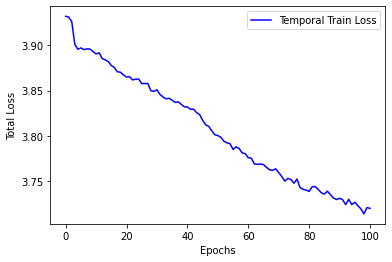

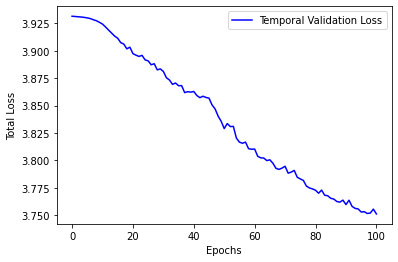

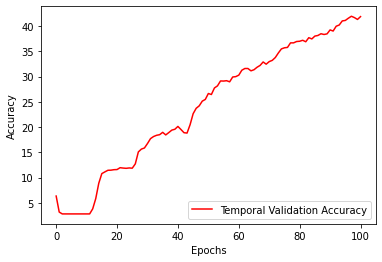

In [16]:
import matplotlib.pyplot as plt


EPOCH_SAVE_PREFIX = '/content/drive/Shared drives/CIS680 Final Project/models/temporal_new_data/'

# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.random.manual_seed(1)

# Load params
last_epoch = 100

# load data
network_path = EPOCH_SAVE_PREFIX + 'temporal_epoch' + str(last_epoch)
checkpoint = torch.load(network_path)
train_loss_list = checkpoint['train_total_loss_list']
epoch_loss_list = checkpoint['epoch_total_loss_list']
train_counter = checkpoint['train_counter']
test_loss_list = checkpoint['test_loss_list']
accuracy_list = checkpoint['accuracy_lsit']
epoch_list = np.arange(last_epoch+1)


# plots
fig = plt.figure()
plt.plot(epoch_loss_list, color='blue')
plt.legend(['Temporal Train Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Total Loss')

fig = plt.figure()
plt.plot(test_loss_list, color='green')
plt.legend(['Temporal Validation Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Total Loss')

fig = plt.figure()
plt.plot(accuracy_list, color='red')
plt.legend(['Temporal Validation Accuracy'], loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.show()